Displaying the Board

In [1]:
import math
from PIL import Image

NUM_COLUMN = 5
NUM_ROW = 5

In [2]:
def playerToColor(player):
  if player == 1: return 'r'
  return 'b'

In [3]:
def get_board_element(prob, player):
    square = Image.new(mode="RGB", size=(100, 100))
    pixel_map = square.load()
    width, height = square.size
    for i in range(width):
        for j in range(height):

            if(math.sqrt((i - width/2)*(i - width/2)+(j - height/2)*(j - height/2)) < width/2):

                # RGB value of orange.
                pixel_map[i, j] = (255,255,255)
                
                #if(math.sqrt((i - width/2)*(i - width/2)+(j - height/2)*(j - height/2)) >= (width/2)*(1 - (prob/8))):
                if(j > (1 - (prob/8))*height):
                    if (player == 'r'):
                        pixel_map[i, j] = (224, 90, 55)
                    if (player == 'b'):
                        pixel_map[i, j] = (62,54,52)
                    
            # the following else part will fill the
            # rest part with color yellow
            else:

                # RGB value of classic connect4
                pixel_map[i, j] = (245,216,75)
    return square

In [4]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

In [5]:
def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

In [6]:
def displayBoard():
    board = ['0'] * NUM_COLUMN * NUM_ROW
    probabilities = [0] * NUM_COLUMN * NUM_ROW

    for i in range(NUM_COLUMN):
        for j in range(len(movesByColumn[i])):
          move = movesByTime[movesByColumn[i][j]]
          board[i + (NUM_ROW - 1 - j) * NUM_COLUMN] = playerToColor(move.player)
          if i == move.col1:
            probabilities[i + (NUM_ROW - 1 - j) * NUM_COLUMN] = move.prob1
          else:
            probabilities[i + (NUM_ROW - 1 - j) * NUM_COLUMN] = move.prob2
    
    output = get_board_element(probabilities[0],board[0])
    for i in range(1, NUM_COLUMN):
        output = get_concat_h(output, get_board_element(1,board[i]))
        
    for j in range(1, NUM_ROW):  
        row = get_board_element(probabilities[j * NUM_COLUMN],board[j*NUM_COLUMN])
        for i in range(1, NUM_COLUMN):
            row = get_concat_h(row, get_board_element(probabilities[i + j * NUM_COLUMN],board[i + j * NUM_COLUMN]))
        output = get_concat_v(output, row)
        
    display(output)

Random Number Generation

Version for local testing:

In [7]:
import random
def get_collapsed_piece(n):
  n = (n + 8) % 8
  return random.getrandbits(3) >= n

Version on the quantum computer:

In [ ]:
def _get_bits_from_counts(counts):
    for k, v in counts.items():
      if v ==1:
          return k

In [ ]:
def _request_bits(n):
  global _bitCache
  global _circuit
  iterations = math.ceil(n * 2/_circuit.width())
  for _ in range(iterations):
    job = _backend.run(_circuit, shots=1)
    _bitCache += _get_bits_from_counts(job.result().get_counts())

In [ ]:
def _get_bit_string(n):
  global _bitCache
  if len(_bitCache) < n:
    _request_bits(n-len(_bitCache)) #request as many bits as we are lacking
  bitString = _bitCache[0:n] #result is the first n bits of the bitCache
  _bitCache = _bitCache[n:] #delete the first n bits of the bitCache
  return bitString

In [ ]:
def get_collapsed_piece(n): # there is a n/8 chance that the piece collapses to left
  n = n % 8
  measure = _get_bit_string(3)
  return measure >= n # 0 is left and 1 is right

In [8]:
def measure(col):
  movesForCol = movesByColumn[col].copy()
  # output: 
  for t in movesForCol:
    move = movesByTime[t]
    # If the move is not already collapsed
    if move.prob2 != 0:
      # Get what the piece collapses to
      whichMove = get_collapsed_piece(move.prob1)
      # If the piece collapsed to column 2
      if whichMove == True:
        # Rename so the piece collapsed to "column 1" (i.e. swap columns 1 and 2)
        move.col1, move.col2 = move.col2, move.col1
      # Either way, one probability is 1 and the other is 0
      move.prob1, move.prob2 = MAX_PROB, 0
      # This move no longer affect column 2
      movesByColumn[move.col2].remove(t)
  # At this point, all moves in this column are collapsed, so if the columns is still full, mark so!
  if len(movesByColumn[col])==NUM_ROW:
    fullColumns[col]=1

QConnect 4!

In [9]:
NUM_COLUMN = 5
NUM_ROW = 5
MAX_PROB = 8
# Initialize game state
movesByTime = []
movesByColumn = [[] for i in range(NUM_COLUMN)]
fullColumns = [0 for i in range(NUM_COLUMN)]
time = 0
curPlayer = 0

In [10]:
def initialize():
  global movesByTime, movesByColumn, fullColumns, time, curPlayer
  movesByTime = []
  movesByColumn = [[] for i in range(NUM_COLUMN)]
  fullColumns = [0 for i in range(NUM_COLUMN)]
  time = 0
  curPlayer = 0

In [11]:
class Move:
    def __init__(self, i, c1, c2, p1, p2, pl):
        self.index = i
        # Ensure Column 1 is "dominant" in probability; in particular, ensure if
        # a probability is 0 then it's Prob 2
        if p1 < p2:
            c1, c2 = c2, c1
            p1, p2 = p2, p1
        self.col1 = c1
        self.col2 = c2
        self.prob1 = p1
        self.prob2 = p2
        self.player = pl

In [55]:
def getMove(pl):
  global time
  # Display valid move inputs (which columns are valid? How to input probabilities? What to do if they don't want
  # to use a superposition?)

  legalMoves = []
  for i in range(NUM_COLUMN):
    if not fullColumns[i]:
      legalMoves.append(str(i))

  # Prompt for primary column choice
  print("Possible moves:\n")
  print(legalMoves)
  print("Choose a column:\n")
  c1 = input().strip()
  while c1 not in legalMoves:
    print("Invalid input. Try again.\n")
    print("Possible moves:\n")
    print(legalMoves)
    print("Choose a column:\n")
    c1 = input().strip()
  legalMoves.remove(c1)
  c1 = int(c1)

  # prompt for option to superimpose another column
  print("Do you want to superimpose another column? (Y/N):\n")
  opt = input().strip().upper()
  while (opt != 'Y') and (opt != 'N'):
    print("Invalid input. Try again.\n")
    print("Do you want to superimpose another column? (Y/N):\n")
    opt = input().strip().upper()

  if opt == 'Y':
    # prompt for secondary column choice
    print("Possible moves:\n")
    print(legalMoves)
    print("Choose a second column:\n")
    c2 = input().strip()
    while c2 not in legalMoves:
      print("Invalid input. Try again.\n")
      print("Possible moves:\n")
      print(legalMoves)
      print("Choose a second column:\n")
      c2 = input().strip()
    c2 = int(c2)

    # prompts probability
    options = [str(i) for i in range(1, MAX_PROB)]
    legalProbs = ""
    for i in options:
      legalProbs = legalProbs + f"({i}): {i}/{MAX_PROB}\n"
    print("Pick a number from 1 to 7 corresponding to the probability of the second column:\n")
    print(f"Available choices: \n{legalProbs} \n")
    p2 = input().strip()
    while p2 not in options:
      print("Invalid input. Try again.\n")
      print("Enter a probability for the second column:\n")
      print(f"Choose one: {legalProbs} \n")
      p2 = input().strip()
    p2 = int(p2)
    p1 = 8 - p2
  else:
    # when no superposition occurs
    c2 = c1
    p1 = MAX_PROB
    p2 = 0

  newMove = Move(time, c1, c2, p1, p2, pl)
  # if c1 and c2 are full, a piece is not played
  isFull_c1 = checkMeasure(c1)
  isFull_c2 = checkMeasure(c2)
  # print(isFull_c1)
  # print(isFull_c2)
  if isFull_c1 & isFull_c2:
    print("Both columns are full! No piece is played. Unlucky.\nNext player's turn!\nInput anything to continue:\n")
    input()
    return
  if isFull_c1:
    print("First column is full! Piece must go in second inputted column.\nInput anything to continue:\n")
    input()
    # newMove becomes 100% c2
    newMove.col1 = c2
    newMove.prob1 = MAX_PROB
    newMove.prob2 = 0
  if isFull_c2:
    print("Second column is full! Piece must go in first inputted column.\nInput anything to continue:\n")
    input()
    # newMove becomes 100% c1
    newMove.col2 = c1
    newMove.prob1 = MAX_PROB
    newMove.prob2 = 0

  # add to movesByTime
  movesByTime.append(newMove)
  time += 1
  # add to movesByColumn
  movesByColumn[newMove.col1].append(newMove.index)
  if newMove.prob2 > 0:
    movesByColumn[newMove.col2].append(newMove.index)
  if len(movesByColumn[newMove.col1]) == NUM_ROW and newMove.prob1 == MAX_PROB:
    i = 0
    while i < NUM_ROW:
      if movesByTime[movesByColumn[newMove.col1][i]].prob1 < MAX_PROB:
        break
      i += 1
    if i == NUM_ROW:
      fullColumns[newMove.col1] = 1


In [13]:
def checkMeasure(col):
  ret=False
  if len(movesByColumn[col]) == NUM_ROW:
    print("Column " + str(col) + " may be full, measuring...\n")
    measure(col)
    displayBoard()
    if fullColumns[col]:
      print("Column " + str(col) + " is full!")
      ret = True
    print("After measuring, here is the board. Input anything to continue:\n")
    input()
  return ret

In [14]:
def checkDone():
  return sum(fullColumns) == NUM_COLUMN

Classical Connect 4 at the end...

In [15]:
def checkWin(row, col):
  assert(0 <= row < NUM_ROW)
  assert(0 <= col < NUM_COLUMN)
  # Check row for win
  x, y=row, row
  i = row + 1
  while i < NUM_ROW:
    if board[i][col] != board[row][col]:
      x = i - 1
      break
    i += 1
  if i == NUM_ROW:
    x = NUM_ROW - 1
  i = row - 1
  while i > -1:
    if board[i][col] != board[row][col]:
      y = i + 1
      break
    i -= 1
  if i == -1:
    y = 0
  if x - y + 1 >= 4:
    return True
  
  # Check col for win
  x, y = col, col
  j = col + 1
  while j < NUM_COLUMN:
    if board[row][j] != board[row][col]:
      x = j - 1
      break
    j += 1
  if j == NUM_COLUMN:
    x = j - 1
  j = col - 1
  while j > -1:
    if board[row][j] != board[row][col]:
      y = j + 1
      break
    j -= 1
  if j == -1:
    y = 0
  if x - y + 1 >= 4:
    return True

  # Check diagonal 1 for win
  x, y = 0, 0
  i = 1
  while row + i < NUM_ROW and col+i < NUM_COLUMN:
    if board[row + i][col + i] != board[row][col]:
      x = i - 1
      break
    i += 1
  if row + i == NUM_ROW or col + i == NUM_COLUMN:
    x = i - 1
  i = -1
  while row + i > -1 and col + i > -1:
    if board[row + i][col + i] != board[row][col]:
      x = i + 1
      break
    i -= 1
  if row + i == -1 or col + i == -1:
    y = i + 1
  if x - y + 1 >= 4:
    return True

  # Check diagonal 2 for win
  x, y = 0, 0
  i = 1
  while row + i < NUM_ROW and col - i > -1:
    if board[row + i][col - i] != board[row][col]:
      x = i - 1
      break
    i += 1
  if row + i == NUM_ROW or col - i == -1:
    x = i - 1
  i = -1
  while row + i > -1 and col - i < NUM_COLUMN:
    if board[row + i][col - i] != board[row][col]:
      x = i + 1
      break
    i -= 1
  if row + i == -1 or col - i == NUM_COLUMN:
    y = i + 1
  if x - y + 1 >= 4:
    return True

  return False

In [16]:
def classicConnectFour():
  curInColumn = [0 for i in range(NUM_COLUMN)]
  winner = -1
  for t in range(len(movesByTime)):
    move = movesByTime[t]
    curRow = curInColumn[move.col1]
    board[move.col1][curRow]=move.player
    curInColumn[move.col1]+=1
    if checkWin(curRow, move.col1):
      winner = move.player
      break
  # displayClassic()
  print("Player " + winner + " won! Congrats!")

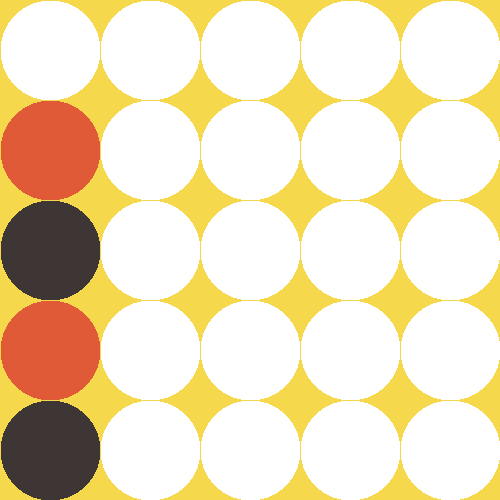

Current player's turn: 1
Possible moves:

['0', '1', '2', '3', '4']
Choose a column:

Do you want to superimpose another column? (Y/N):



KeyboardInterrupt: 

In [56]:
from IPython.display import clear_output
# Initial interaction with player(s)
print("Welcome to Connect 4 - Quantum Edition!")
initialize()
displayBoard()
while not checkDone():
  print("Current player's turn: "+str(curPlayer+1))
  getMove(curPlayer)
  clear_output(wait=True)
  displayBoard()
  curPlayer = 1-curPlayer
# Classic board
# NOTE: ELEMENTS ARE INDEXED BY [row][col] NOT THE OTHER WAY AROUND!
board = [[-1 for i in range(NUM_COLUMN)] for j in range(NUM_ROW)]
classicConnectFour()